# K-Nearest Neighbour (KNN) with Numpy only

In [89]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img

## **Dataset**

In [90]:
dataset_path = "dataset/house_type_dataset_1200.csv"
distance_metric = "e" # m or e
k = 3

x_new = np.array([
    120,  # Area
    3,    # Rooms
    10,   # BuildingAge
    5.0,  # DistanceToCenter
    4,    # Floor
    1,    # HasElevator
    1    # HasParking
])

In [105]:
df = pd.read_csv(dataset_path)
df.head()

,Area,Rooms,BuildingAge,DistanceToCenter,Floor,HasElevator,HasParking,TypeCategory
0,127,3,0,9.6,5,1,1,4
1,105,3,20,14.5,5,1,1,2
2,132,3,60,3.3,1,0,1,3
3,163,4,18,2.1,5,1,1,4
4,101,2,34,13.2,3,1,1,1


In [92]:
dataset_array = df.to_numpy()
x = dataset_array[:, :len(df.columns)-1] # features
y = dataset_array[:, -1] # lables

In [93]:
labels_name = {
    0: "Economy",
    1: "Lower-Mid",
    2: "Mid",
    3: "Upper-Mid",
    4: "Luxury"
}

## **Custom Methods**

In [94]:
def dimension_test(X, x_new):
    assert X.shape[1] == x_new.shape[0]

In [95]:
def standardize(X): # Feature scaling is mandatory for KNN.
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0, ddof=0)
    return (X - mean) / (std + 1e-8)

def pca(X, x_new, k_dim=2):
    cov_matrix = np.cov(X.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]
    top_k_eigenvectors = eigenvectors[:, idx[:k_dim]]
    X_pca = X.dot(top_k_eigenvectors)

    x_new_pca = x_new.dot(top_k_eigenvectors)

    return X_pca, x_new_pca

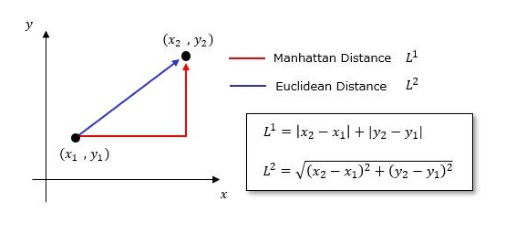

In [96]:
def euclidean(a, b):
    return np.sqrt(np.sum((a - b) ** 2, axis=1)) # or np.linalg.norm(X_train - x_new, axis=1)

def manhattan(a, b):
    return np.sum(np.abs(a - b), axis=1)

img1 = img.imread("euclidean-vs-manhattan-image-by-pawan-yadav.jpg")
plt.axis("off")
plt.imshow(img1)

## **Algorithm**

In [97]:
def knn_predict(X_train, y_train, x_new, k, metric="e"):

    if metric == "e":
        distances = euclidean(X_train, x_new)
    elif metric == "m":
        distances = manhattan(X_train, x_new)
    else:
        raise ValueError("Unsupported metric")

    k_idx = np.argsort(distances)[:k]
    k_distances = distances[k_idx]
    k_labels = y_train[k_idx]

    # Avoid division by zero
    weights = 1 / (k_distances + 1e-8)

    votes = {}
    for label, weight in zip(k_labels, weights):
        votes[label] = votes.get(label, 0) + weight

    return max(votes, key=votes.get)

- Implemented weighted KNN to reduce sensitivity to noisy neighbors.

## **Inference**

In [98]:
# dimension_test(x, x_new)
# preprocessing
x_scaled = standardize(x)
x_new_scaled = standardize(x_new)
X, x_new = pca(x_scaled, x_new_scaled)

# prediction
y_pred = knn_predict(X, y, x_new, k, distance_metric)

# get the label name
y_pred_label = labels_name.get(y_pred)
print(f"{y_pred}: this is a/an {y_pred_label} house!")

4.0: this is a/an Luxury house!


## **Reports**

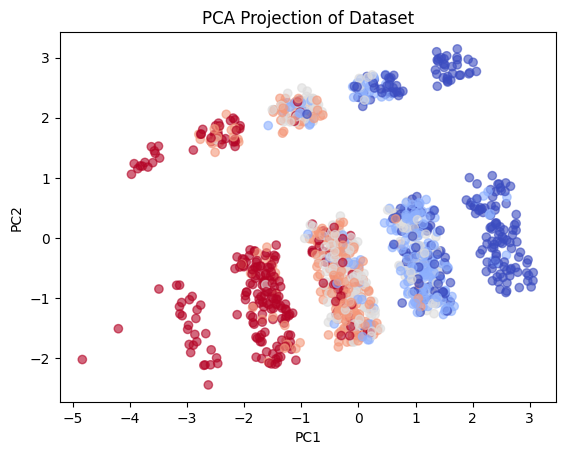

In [101]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", alpha=0.6)
plt.title("PCA Projection of Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

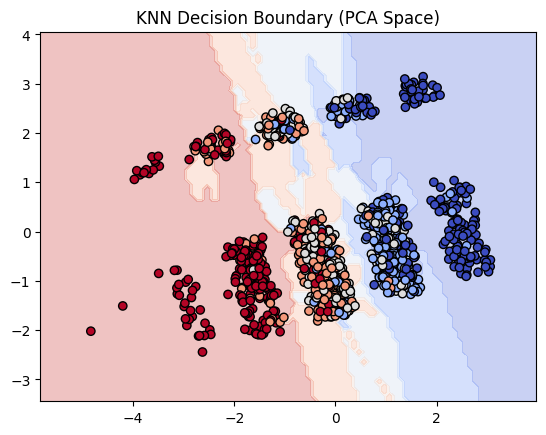

In [102]:
h = 0.1
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)

grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([knn_predict(X, y, point, k=7) for point in grid])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolors="k")
plt.title("KNN Decision Boundary (PCA Space)")
plt.show()

> 💡 **The middle classes overlap due to intrinsic similarity in feature space, which reflects real-world housing data rather than a modeling error.**